In [1]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.projections import get_projection_class

sys.path.append('../modules')
from timeseries import select_months

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## read unique landslide dates
df = pd.read_csv('../out/non-landslide_dates.csv')
df = df.set_index(pd.to_datetime(df['init_date'], format='%Y-%m-%d'))
final_dates_lst = df.index

date_lst = []
impact_date_lst = []
model_lst = []
F_lst = []
for i, date in enumerate(final_dates_lst):
    ## skip 2 events - 20200227, 20200817
    ## the data from GEFS was too hard to download for these dates
    if (date.strftime("%Y%m%d") == '20200227') | (date.strftime("%Y%m%d") == '20200817'):
        pass
    else:
        for j, init_lead in enumerate(np.arange(1, 8)):
            F_lst.append(init_lead*24) # lead in hours
            init_date = date - pd.to_timedelta(init_lead, unit='D')
            date_lst.append(init_date)
            impact_date_lst.append(date)
            
            if init_date.year < 2020:
                model_name = 'GEFSv12_reforecast'
            else:
                model_name = 'GEFS_archive'
    
            model_lst.append(model_name)

d = {'impact_date': impact_date_lst, 'init_date': date_lst, 'model_name': model_lst, 'F': F_lst}
df = pd.DataFrame(d)

## cut the df so it takes out init dates before 2000-01-01
idx = (df['init_date'] >= '2000-01-01')
df = df.loc[idx]
df

,impact_date,init_date,model_name,F
7,2000-01-02,2000-01-01,GEFSv12_reforecast,24
14,2000-01-03,2000-01-02,GEFSv12_reforecast,24
15,2000-01-03,2000-01-01,GEFSv12_reforecast,48
21,2000-01-04,2000-01-03,GEFSv12_reforecast,24
22,2000-01-04,2000-01-02,GEFSv12_reforecast,48
...,...,...,...,...
50752,2019-12-31,2019-12-28,GEFSv12_reforecast,72
50753,2019-12-31,2019-12-27,GEFSv12_reforecast,96
50754,2019-12-31,2019-12-26,GEFSv12_reforecast,120
50755,2019-12-31,2019-12-25,GEFSv12_reforecast,144


In [4]:
IVT_lst = []
Z0_lst = []
UV_lst = []
QPF_lst = []
AR_index_lst = []
for index, row in df.iterrows():
    ## read csv files from landslide dates
    model_name = row['model_name']
    F = row['F']
    
    fdate = row['init_date'].strftime("%Y%m%d")
    impact_date = row['impact_date'].strftime("%Y-%m-%d")
    try:
        ## for each row, open the file using the init date
        fname = '/expanse/nfs/cw3e/cwp140/csv_non-landslide_historical/mclimate_init{0}.csv'.format(fdate)
        test = pd.read_csv(fname)
        test["valid_time"] = row['init_date'] + pd.to_timedelta((test.index + 1) * 6, unit="h")
        test = test.set_index(pd.to_datetime(test['valid_time']))
        ## then subset to impact date
        subset = test.loc[impact_date]
        
        ## pull the maximum values for each var
        IVT_lst.append(subset['IVT'].max())
        Z0_lst.append(subset['Freezing Level'].max())
        UV_lst.append(subset['UV'].max())
        QPF_lst.append(subset['QPF'].max())
        AR_index_lst.append(subset['AR_index'].max())
    except FileNotFoundError:
        print('Skipping {0}, data not available...'.format(fdate))
        ## set vals to nan
        IVT_lst.append(np.nan)
        Z0_lst.append(np.nan)
        UV_lst.append(np.nan)
        QPF_lst.append(np.nan)
        AR_index_lst.append(np.nan)
        

df['IVT'] = IVT_lst
df['Z0'] = Z0_lst
df['UV'] = UV_lst
df['QPF'] = QPF_lst
df['AR_index'] = AR_index_lst
df

Skipping 20060330, data not available...
Skipping 20060330, data not available...
Skipping 20060330, data not available...
Skipping 20060330, data not available...
Skipping 20060330, data not available...
Skipping 20060330, data not available...
Skipping 20060330, data not available...


,impact_date,init_date,model_name,F,IVT,Z0,UV,QPF,AR_index
7,2000-01-02,2000-01-01,GEFSv12_reforecast,24,0.0,0.0,75.0,90.0,0.5
14,2000-01-03,2000-01-02,GEFSv12_reforecast,24,75.0,75.0,93.0,97.0,0.5
15,2000-01-03,2000-01-01,GEFSv12_reforecast,48,0.0,0.0,90.4,93.0,0.5
21,2000-01-04,2000-01-03,GEFSv12_reforecast,24,92.0,75.0,90.0,98.0,1.0
22,2000-01-04,2000-01-02,GEFSv12_reforecast,48,92.0,75.0,93.0,98.0,0.5
...,...,...,...,...,...,...,...,...,...
50752,2019-12-31,2019-12-28,GEFSv12_reforecast,72,75.0,75.0,94.0,97.0,1.0
50753,2019-12-31,2019-12-27,GEFSv12_reforecast,96,75.0,75.0,94.0,97.0,1.0
50754,2019-12-31,2019-12-26,GEFSv12_reforecast,120,75.0,75.0,93.0,94.0,0.5
50755,2019-12-31,2019-12-25,GEFSv12_reforecast,144,75.0,75.0,97.0,97.0,1.0


In [13]:
# idx = (df['impact_date'] == '2005-11-23')
# test = df.loc[idx]
# test

idx = (df['QPF'] >= 98.) & (df['IVT'] >= 98.)
test = df.loc[idx]
test

,impact_date,init_date,model_name,F,IVT,Z0,UV,QPF,AR_index
161,2000-01-28,2000-01-27,GEFSv12_reforecast,24,98.0,75.0,99.0,99.0,2.0
175,2000-01-30,2000-01-29,GEFSv12_reforecast,24,98.0,75.0,98.0,99.0,1.5
490,2000-03-15,2000-03-14,GEFSv12_reforecast,24,98.0,75.0,99.0,99.0,2.0
491,2000-03-15,2000-03-13,GEFSv12_reforecast,48,98.0,75.0,99.0,98.0,1.5
567,2000-03-26,2000-03-25,GEFSv12_reforecast,24,99.0,92.0,98.0,99.0,2.0
...,...,...,...,...,...,...,...,...,...
50449,2019-11-21,2019-11-20,GEFSv12_reforecast,24,98.0,75.0,99.0,98.0,2.0
50450,2019-11-21,2019-11-19,GEFSv12_reforecast,48,98.0,75.0,98.0,98.0,2.5
50451,2019-11-21,2019-11-18,GEFSv12_reforecast,72,98.0,75.0,98.0,98.0,2.0
50452,2019-11-21,2019-11-17,GEFSv12_reforecast,96,98.0,75.0,98.0,98.0,2.5


In [6]:
idx = (df['AR_index'] > 3)
test = df.loc[idx]
test_dates = test.sort_values(by="AR_index", ascending=False).impact_date
print(test_dates.values)

['2002-11-26T00:00:00.000000000' '2002-11-26T00:00:00.000000000'
 '2002-11-26T00:00:00.000000000' '2002-11-27T00:00:00.000000000'
 '2002-11-27T00:00:00.000000000' '2002-11-27T00:00:00.000000000'
 '2002-11-27T00:00:00.000000000' '2002-11-27T00:00:00.000000000'
 '2005-11-23T00:00:00.000000000' '2005-11-23T00:00:00.000000000'
 '2005-11-23T00:00:00.000000000' '2005-11-23T00:00:00.000000000']


In [7]:
ssn = 'all'
# ## read csv
# fname = path_to_out + 'box_whisker_2000-2019.csv'
# df1 = pd.read_csv(fname)

# fname = path_to_out + 'box_whisker_2020-2024.csv'
# df2 = pd.read_csv(fname)

# df = pd.concat([df1, df2])
# df['IVT'] = df['IVT']*100
# df['Z0'] = df['Z0']*100
# df['UV'] = df['UV']*100

df = df.set_index(pd.to_datetime(df['impact_date']))
if ssn == 'DJF':
    df = select_months(df, 12, 2)
elif ssn == 'cool-season':
    df = select_months(df, 9, 2)
else:
    df = df
df
df = df.reset_index(drop=True)

In [14]:
df = df.sample(n=100, random_state=42)

In [15]:
F_lst = np.arange(24, 168+24, 24)
varlst = ['IVT', 'Z0', 'UV', 'QPF', 'AR_index']
for j, F in enumerate(F_lst):
    print('F = {0}'.format(F))
    idx = (df.F == F)
    tmp = df.loc[idx]
    tmp = tmp.drop(columns=["impact_date", "init_date", "F"])
    print(tmp.describe())

F = 24
             IVT         Z0         UV        QPF   AR_index
count  12.000000  12.000000  12.000000  12.000000  12.000000
mean   88.750000  74.500000  90.166667  86.100000   1.083333
std    10.393398  35.973475   9.456439  27.848486   0.417424
min    75.000000   0.000000  75.000000   0.000000   0.500000
25%    75.000000  75.000000  87.000000  92.000000   1.000000
50%    94.000000  93.500000  94.500000  95.600000   1.000000
75%    96.250000  96.000000  97.250000  97.000000   1.125000
max    99.000000  99.000000  98.000000  99.000000   2.000000
F = 48
             IVT         Z0         UV        QPF   AR_index
count  15.000000  15.000000  15.000000  15.000000  15.000000
mean   66.266667  29.866667  87.360000  90.920000   0.633333
std    35.374459  43.949430   9.332034   7.554582   0.228869
min     0.000000   0.000000  75.000000  75.000000   0.500000
25%    75.000000   0.000000  75.000000  92.500000   0.500000
50%    75.000000   0.000000  91.000000  94.000000   0.500000
75%    91.

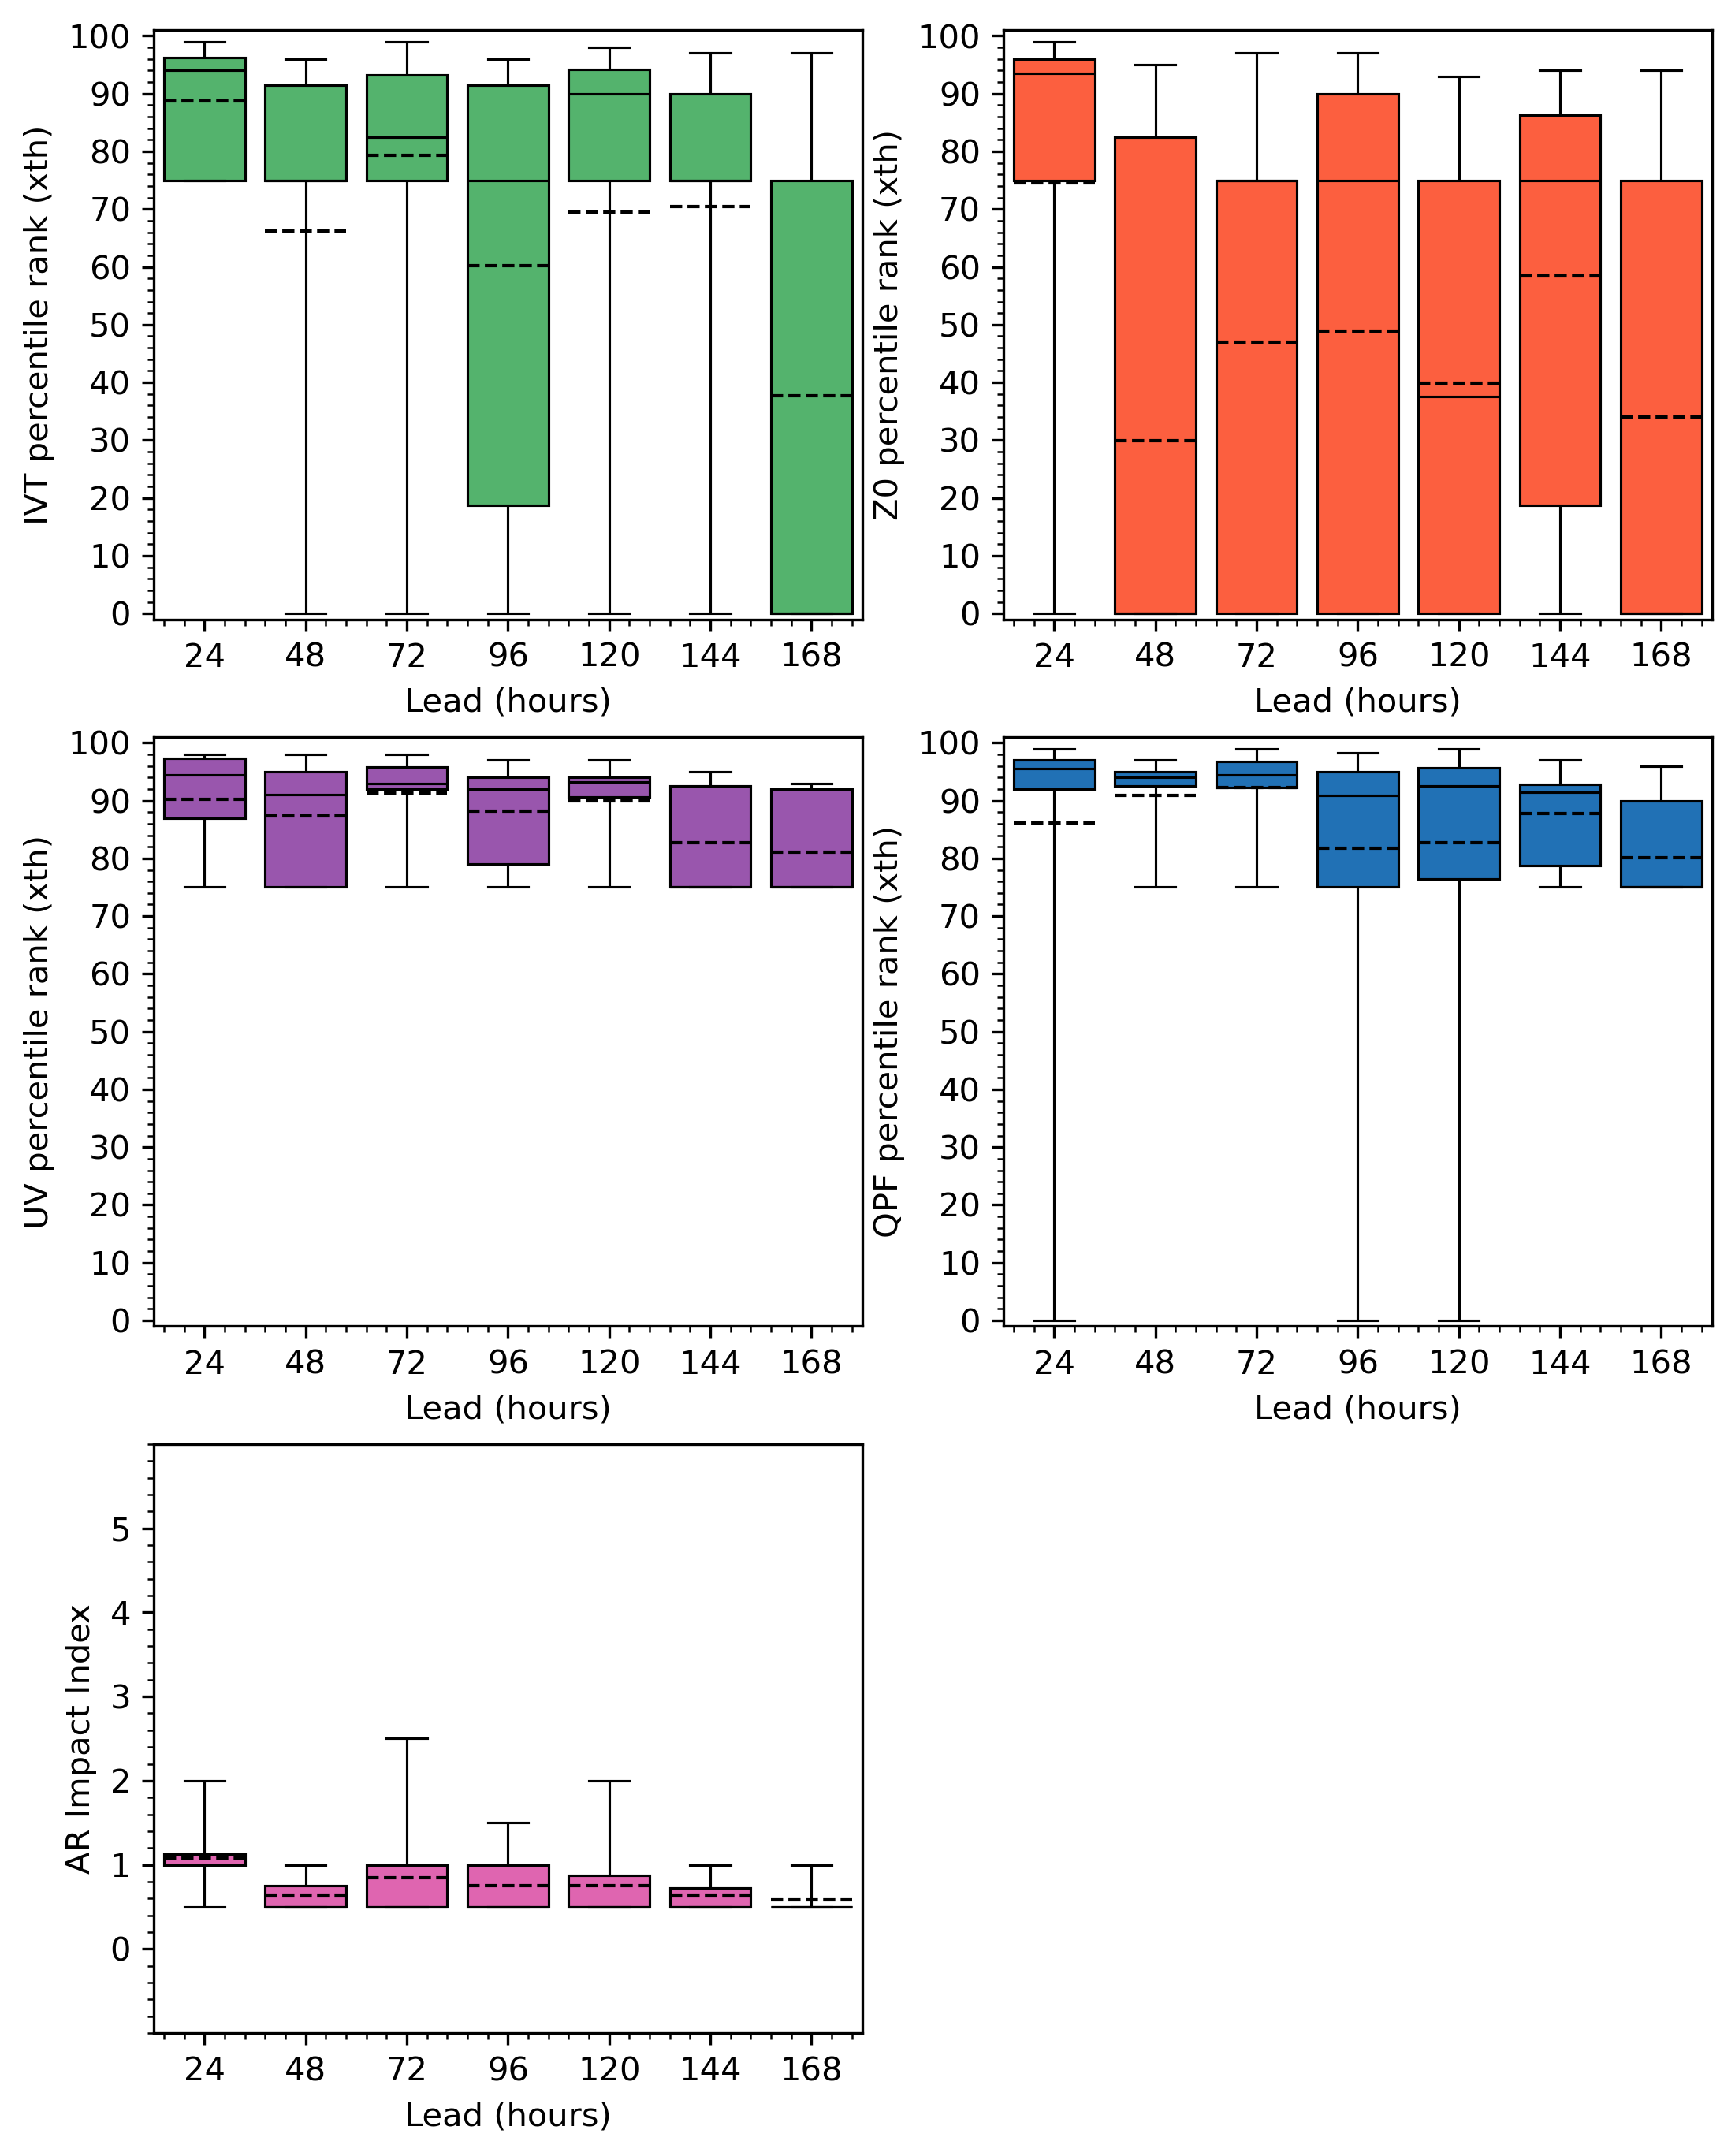

In [16]:
# Create figure
fig = plt.figure(figsize=(8.5, 11))
fig.dpi = 300
fname = path_to_figs + 'non_landslide_box_whisker_{0}'.format(ssn)
fmt = 'png'

nrows = 3
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1], width_ratios = [1, 1], wspace=0.2, hspace=0.2)
## use gs[rows index, columns index] to access grids

#######################
### BOX AND WHISKER ###
#######################
varname_lst = ['IVT', 'Z0', 'UV', 'QPF', 'AR_index']
color_lst = ['#54B36D', '#FC5F3F', '#9956AD', '#2171b5', '#DF65B0']
row_lst = [0, 0, 1, 1, 2]
col_lst = [0, 1, 0, 1, 0]
for i, varname in enumerate(varname_lst):
    ax = fig.add_subplot(gs[row_lst[i], col_lst[i]])
    PROPS = {'boxprops':{'facecolor':color_lst[i], 'edgecolor':'k'},
             'medianprops':{"color": "k"},
             'whiskerprops':{"color": "k"},
             'capprops':{"color": "k"},
             'flierprops':{"marker": "x"},
             'meanprops':{'c':'k', 'lw':1},
             'bootstrap': 5000}
    
    bplot = sns.boxplot(y=varname, x="F", data=df, 
                        whis=[0, 100],
                    order=np.arange(24, 8*24, 24),
                    meanline=True, showmeans=True, 
                    notch=False, showcaps=True,
                    linewidth=0.75,
                    **PROPS)
    
    #  set the ticks first
    if varname == 'AR_index':
        plt.ylim(-1., 6)
        bplot.set_yticks(np.arange(0., 6, 1))
    else:
        plt.ylim(-1., 101)
        bplot.set_yticks(np.arange(0., 101, 10))
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', bottom=True)
    ax.tick_params(axis='y', which='major')
    
        
    # ax.set_title('(a)', loc='left')
    # ax.annotate(plt_lbl[i], (5, 207), xycoords='axes points', fontsize=12.,
    #         backgroundcolor='white', zorder=100)
    if i <= 3:
        ax.set_ylabel('{0} percentile rank (xth)'.format(varname))
    else:
        ax.set_ylabel('AR Impact Index')
    ax.set_xlabel('Lead (hours)')


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)

# Show
plt.show()